## The relationship between chemical potential and energy matrix quality

We create energy matrices by performing Sort-Seq, a process in which mutations to a promoter cause changes in the expression of a fluorescent reporter, so that we can sort cells based on their fluorescence and connect mutated promoter sequences to their respective expression levels. We have seen that increasing the number of repressors and the energy of the wt operator can both improve the quality of our energy matrices, where quality is measured by the matrices' ability to accurately predict the binding energies of mutant operators. This is likely related to the fact that our promoter of interest is present in multiple copies on plasmids, which introduces the complicating factor that the number of transcription factors in the system may be similar to or even smaller than the number of promoters available in the system. One way to explore this effect is by considering the chemical potential of the system. Both $R$ and the wt binding energy $\Delta \varepsilon_\text{wt}$ are key components in the chemical potential, as discussed in Weinert *et al.* (2014). Here, I would like to explore how the chemical potential of the system is connected to our ability to distinguish highly-expressing mutants from low-expressing mutants. 

In [1]:
# Import essential packages
import numpy as np
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
import seaborn as sns
import sys

# Import the project utils
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
mwc.set_plotting_style()

# Set color scheme
colors=sns.color_palette('RdPu_r', 6)[1:]
colors_alt=sns.color_palette('Blues')
colors_qual=sns.color_palette(
    ['#bf0087', '#e5b600', '#40ac00', '#5233ea', '#bf3800', '#00acac'])

sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The relationship between the chemical potential $\mu$ and $\Delta
\varepsilon_R$ is evident in the generalized equation for the probability of TF
binding, given by

\begin{equation}
p_{bound} = \frac{1}{1 + e^{-\beta(\Delta\varepsilon_R - \mu)}},
\end{equation}

where $\beta = 1/k_BT$ and $\Delta \varepsilon_R$ is the repressor-operator binding energy in $k_BT$ units. Because we assume that $p_{bound}$ is proportional to expression level, we can see from this expression that the chemical potential will affect the level of expression observed during Sort-Seq. To relate the chemical potential more explicitly to our system, we define the fugacity parameter $\lambda = e^{\beta \mu}$. The fugacity is related both to the number of repressors in a simple repression system and $\Delta \varepsilon_R$ by the equations

\begin{equation}
\langle R_s \rangle = N_s \frac{\lambda e^{-\beta \Delta\varepsilon_R}}{1 + \lambda e^{-\beta \Delta\varepsilon_R}}
\end{equation}

and

\begin{equation}
\langle R_{ns} \rangle = N_{ns} \frac{\lambda}{1 + \lambda}, 
\end{equation}

where $R_s$ is the number of repressors specifically bound to the operator, $N_s$ is the number of operator sites in the system, $R_{ns}$ is the number of repressors nonspecifically bound to the genome, and $N_{ns}$ is the number of nonspecific sites available in the genome. The total number of repressors in the system is defined as $\langle R_{tot} \rangle = \langle R_s \rangle + \langle R_{ns} \rangle$. It is difficult to solve for $\lambda$ analytically, but we can easily obtain it numerically.

In [2]:
# Define a function that solves for the fugacity.

def fugacity(R, N, Op):
    '''
    Solves for the fugacity of a simple repression system. 
    
    INPUTS
    ------
    R: float, the number of repressors per cell
    N: float, the number of identical operators in the system
    Op: float, the repressor-operator binding energy in k_BT units
    
    OUTPUTS
    -------
    The fugacity of the simple repression system.
    '''
    NNS = 5E6
    x = Symbol('x')
    lam = solve(-R + N*(x * np.exp(-Op))/(1 + x * np.exp(-Op)) + NNS * (x)/(1 + x), x)[1]
    return lam

Let's take a look at how the chemical potential changes as we alter $R$ and $\Delta \varepsilon_R$ for a system where $N_s = 10$, meaning that there are 10 identical promoters that can be regulated by the repressor. The vertical gray line indicates the wild-type LacI copy number in *E. coli*. The diagonal gray line indicates how chemical potential scales with repressor copy number when $N_s = 1$.

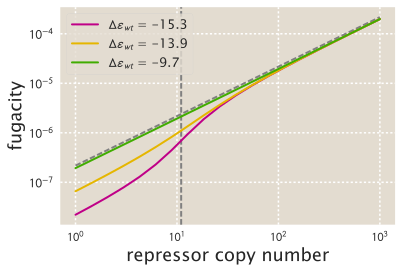

In [3]:
# Define ranges of repressors and binding energies
reps = np.logspace(0, 3, 20)
energies = [-15.3, -13.9, -9.7]

# Plot fugacity as a function of R
for en in energies:
    lam_list = []
    for R in reps:
        lam_list.append(fugacity(R, N=10, Op=en)) 
    plt.loglog(reps, lam_list, label=(r'$\Delta \varepsilon_{wt}$ = %.1f' % en))
plt.loglog(reps, reps/4.6E6, '--', color='gray', zorder=1)
plt.axvline(11, ls='--', color='gray', zorder=1)
plt.xlabel('repressor copy number')
plt.ylabel('fugacity')
plt.legend(loc = 'upper left')

We can similarly see how fugacity scales with $\Delta \varepsilon_R$ for each of the repressor copy numbers used in our study. This is relevant because $\Delta \varepsilon_R$ is the parameter which is varied as the operator is mutated. It is important to note whether this is likely to cause signficant changes to the fugacity, which may alter expression in unanticipated ways.

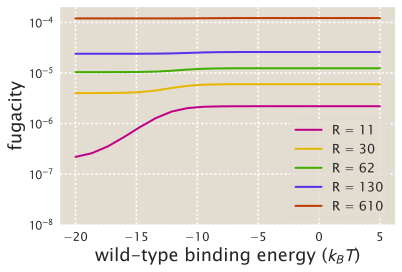

In [4]:
# Define ranges of repressors and binding energies
energies = np.linspace(-20, 5, 20)
reps = [11, 30, 62, 130, 610]

# Plot fugacity as a function of binding energy
for R in reps:
    lam_list = []
    for en in energies:
        lam_list.append(fugacity(R, N=10, Op=en))
    plt.semilogy(energies, lam_list, label=('R = %i' % R))
plt.xlabel(r'wild-type binding energy ($k_BT$)')
plt.ylabel('fugacity')
plt.ylim(1E-8, 2E-4)
plt.legend(loc = 'lower right')

What we see from these plots is that for low repressor copy numbers, fugacity depends strongly on $\Delta \varepsilon_R$ when $\Delta \varepsilon_R < 10 k_BT$. However, as the repressor copy number increases, fugacity no longer varies significantly with $\Delta \varepsilon_R$. Therefore, it may be beneficial to perform Sort-Seq in strains with larger repressor copy numbers so that mutations to the operator do not significantly alter the fugacity.

Finally, we can predict how changes in the fugacity are expected to alter expression. As discussed in Weinert *et al.* (2014), in the weak promoter limit gene expression is entirely governed by the properties of the repressor, and the properties of the RNAP can be ignored. A simple way of quantifying changes in expression due to repression is the fold-change, which is given by 

\begin{equation}
\text{fold-change} = \frac{1}{1 + \lambda e^{-\beta \Delta \varepsilon_R}}.
\end{equation}

We use this expression to assess how changes to the operator binding energy and the resulting changes to fugacity will affect fold-change in a system with multiple promoters on plasmid ($N_s$ = 10).

In [5]:
def fold_change(lam, Op):
    '''
    Calculates fold-change for a simple repression system with 1 or more identical promoters.
    
    INPUTS
    ------
    lam: float, fugacity as calculated by fugacity()
    Op: float, repressor-operator binding energy in k_BT
    
    OUTPUTS
    -------
    fold-change
    '''
    return 1/(1 + lam * np.exp(-(Op)))

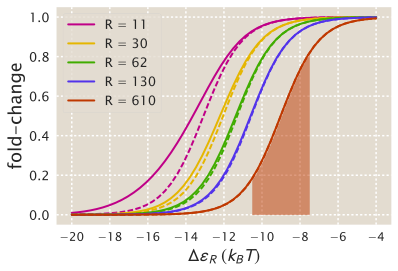

In [6]:
# Establish array of energies and repressor copy numbers
energies = np.linspace(-20, -4, 50)
reps = [11, 30, 62, 130, 610]
NNS = 4.6E6 # Number of nonspecific sites

# Plot fold change as a function of operator binding energy
for i, R in enumerate(reps):
    fold_change_list = []
    fc_simple = []
    for en in energies:
        fold_change_list.append(fold_change(fugacity(R, N=10, Op=en), en))
        fc_simple.append(fold_change(fugacity(R, N=1, Op=en), en))
    plt.plot(energies, fold_change_list, label=('R = %i' % R))
    plt.plot(energies, fc_simple, '--', color = sns.color_palette()[i])

x = np.linspace(-10.5, -7.5, 100)
plt.fill_between(x, 0, fold_change(610/NNS, x), alpha = 0.5, color = sns.color_palette()[i])
plt.xlabel(r'$\Delta \varepsilon_R\ (k_BT)$')
plt.ylabel('fold-change')
_ = plt.legend(loc='upper left')

In the plot above, we see that the value of the repressor-operator binding energy $\Delta \varepsilon_R$ has a significant effect on the fold-change. Crucially, a library of operator mutants will have a distribution of binding energies which we observe as fluorescence in flow cytometry histograms. We see from this plot that if the range of binding energies in a cell population is too high or too low, the range of observed fold-changes will be narrow. For each repressor copy number, there is a "sweet spot" where changes to operator binding energy will cause the greatest change in fold-change. As an example, the shaded region indicates where this sweet spot lies for strains with $R = 610$. Because the ideal range of operator binding energies is different for each value of $R$, one will find that different values of $R$ are ideal for different operator libraries. 

Additionally, the dashed lines in this plot show the curves that would be obtained if one were to assume the simplest model of repression, where there is only a single copy of the promoter available in the system. The overlap between the solid and dashed lines for higher values of $R$ indicates that, while having a promoter on plasmid may affect experiments when $R$ is low, it is not a concern when $R$ is high. 